# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [59]:
import torch
from torch import nn, optim
from sklearn.datasets import load_wine
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [60]:

# 데이터셋 종류 : 
data = load_wine()

In [61]:
input = data.data
output = data.target

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [81]:
print(x_train[0])
print(x_train.shape)

print(y_train[0])
print(y_train.shape)

#input 13개 (속성이 13개)

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03])
torch.Size([124, 13])
tensor(0)
torch.Size([124])


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [79]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [80]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [82]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
    nn.Linear(13, 398, bias=True), 
    nn.Sigmoid(),
    nn.Linear(398, 15, bias=True),
    nn.Sigmoid(),
    nn.Linear(15,3, bias=True), 
    nn.Softmax()
).to(device)


class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [83]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 13, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

- 이전 breast cancer 데이터도 output label이 2개인데도 output layer가 5로 설정되어있고 잘 돌아가길래 이번 데이터 또한 5로 설정해둠

In [84]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [85]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\USER\AppData\Local\Temp\ipykernel_27612\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [86]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [87]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [88]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Windows\System32\myenv\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.5799548625946045
10 1.422746181488037
20 1.3021668195724487
30 1.1942405700683594
40 1.10732901096344
50 1.03164803981781
60 1.0013011693954468
70 0.9627605676651001
80 0.9461923837661743
90 0.9653967022895813


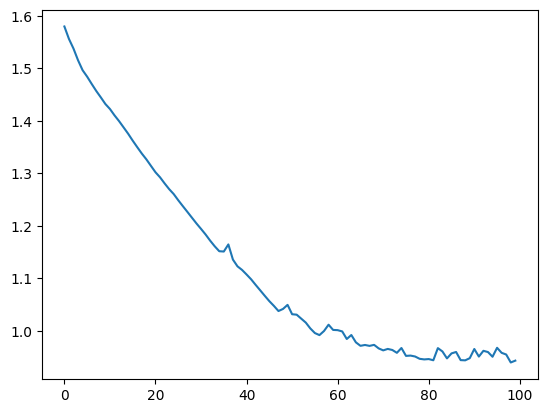

In [89]:
plt.plot(losses)
plt.show()

In [90]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [91]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9733017  0.01560928 0.00824407 0.00105031 0.0017947 ]
argmax를 한 후의 output은 0
accuracy는 0.9444444444444444


# < 3주차 과제 2 : CNN 맛보기>

In [19]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [20]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 15848231.33it/s]


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 15053522.28it/s]

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw




100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 14802596.27it/s]


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2396292.93it/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



In [54]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) 
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(320 , 10) # 알맞는 input은?

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)  
    x = self.fc(x)
    return F.log_softmax(x)

In [55]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [56]:
def train(epoch):
  model.train()  # 훈련 모드로 설정
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()    # gradient 초기화
    output = model(data)
    loss = F.nll_loss(output, target)   # negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [57]:
def test():
    model.eval() #model.eval() 의 기능은?   # 평가 모드로 설정
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)    # 평균 손실
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

- nll_loss: negative log likelihood loss
- cross entropy loss와의 관계: cross entropy는 두 확률 분포 간의 거리가 최소화되도록 학습시키며, NLL은 cross entropy loss에서 정답 클래스에 해당하는 확률의 로그를 취한 것

In [58]:
for epoch in range(1, 10):
    train(epoch)
    test()

C:\Users\USER\AppData\Local\Temp\ipykernel_27612\2638290573.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309309
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.293573
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.296662
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.282233
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.276705
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.252425
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.267917
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.239310
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.219860
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.186896
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.142303
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.075975
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.025887
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.857085
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.670601
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.397461
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.089701
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.117220
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.964369
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.770526
Train Epoch: 1 [12800/60000 (

C:\Users\USER\AppData\Local\Temp\ipykernel_27612\1412383255.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
C:\Windows\System32\myenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1772, Accuracy: 9484/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.096937
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.186270
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.324445
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.251303
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.177348
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.144502
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.136747
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.218501
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.258863
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.073829
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.137388
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.170885
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.199225
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.194255
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.103051
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.257100
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.126356
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.296945
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.110145
Train Epoch: 2 [12

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.040367
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.075582
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.076652
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.249816
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.052060
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.051096
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.036776
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.036809
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.044409
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.162081
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.052684
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.084908
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.044190
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.076864
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.107694
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.282696
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.088295
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.036876
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.122806
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.085221


Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.167361
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.203687
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.108243
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.076906
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.041682
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.196346
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.040728
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.095148
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.087720
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.101088
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.044703
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.118359
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.016017
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.071791
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.022322
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.050030
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.085425
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.081714
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.047795
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.119455


Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.054959
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.053031
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.055352
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.041357
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.011941
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.022041
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.011238
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.073066
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.025230
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.095356
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.191831
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.142769
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.011154
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.067888
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.083316
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.072813
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.173466
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.065520
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.016467
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.034409


Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.022572
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.026741
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.030269
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.041570
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.073421

Test set: Average loss: 0.0661, Accuracy: 9795/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.004104
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.077803
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.036079
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.099306
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.041084
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.021708
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.087443
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.043010
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.105656
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.138257
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.121129
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.073876
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.116029
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.020586
Train Epoch: 9 [